In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request

from collections import Counter
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

In [3]:
train_data = pd.read_table('./dataset/ratings_train.txt')
test_data = pd.read_table('./dataset/ratings_test.txt')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
train_data.head() # 1 : 긍정, 0 : 부정

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
# 중복 데이터 제외한 데이터 수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [9]:
# 중복데이터 제거
train_data.drop_duplicates(subset = ['document'], inplace = True)

In [10]:
len(train_data)

146183

In [11]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [12]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [13]:
# dropna()로 1개 라도 NaN 값이 있는 행은 제거함.
train_data = train_data.dropna(how = 'any')
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [14]:
# dropna()로 1개 라도 NaN 값이 있는 행은 제거함.
test_data = test_data.dropna(how = 'any')
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [15]:
# https://www.unicode.org/charts/PDF/U3130.pdf
# https://www.unicode.org/charts/PDF/UAC00.pdf -> 가 ~ 힣
# 이걸 가지고 한글인지 아닌지 판단하면 됨.
# 정규식 이용. pattern -> [a-zA-Z0-9] (데이터 전처리할 때도 사용)

In [16]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data.head()

C:\Users\user\AppData\Local\Temp/ipykernel_11568/117597620.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [18]:
# 공백이 한 번 이상인 경우 nan 값으로 바꿈.
train_data['document'] = train_data['document'].str.replace('^ +', '')
train_data['document'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum())

C:\Users\user\AppData\Local\Temp/ipykernel_11568/3810662202.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', '')


id            0
document    789
label         0
dtype: int64


In [19]:
# null 데이터 삭제
train_data = train_data.dropna(how = 'any')
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145393 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [21]:
# test 데이터에도 적용.
# 중복데이터 제거
test_data.drop_duplicates(subset = ['document'], inplace = True)
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test_data['document'] = test_data['document'].str.replace('^ +', '')
test_data['document'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how = 'any')
test_data.isnull().sum()

C:\Users\user\AppData\Local\Temp/ipykernel_11568/3717994891.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
C:\Users\user\AppData\Local\Temp/ipykernel_11568/3717994891.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', '')


id          0
document    0
label       0
dtype: int64

In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [23]:
# 한글 데이터만 가지고 작업.
# 토큰화(Konlpy.Okt), 어간 추출, 표제어 추출, 불용어 제거, embedding 임베딩

In [24]:
okt = Okt()
okt.morphs('아 더빙 진짜 짜증나네요 목소리', stem = True)

['아', '더빙', '진짜', '짜증나다', '목소리']

In [25]:
okt.morphs('교도소 이야기구먼 솔직히 재미는 없다평점 조정', stem = True)

['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정']

In [26]:
X_train = []
stopwords = ['은', '는', '이', '가', '시', '로', '을', '를', '다', '의',
            '으로', '로', '에', '와', '과', '에게', '한다', '하다', '한']

In [27]:
for data in tqdm(train_data['document']):
    # 토큰화, stemming
    tokenized_data = okt.morphs(data, stem = True)
    
    # 불용어 처리한 데이터
    _data = []
    for word in tokenized_data:
        if not word in stopwords:
            _data.append(word)
    X_train.append(_data)

100%|█████████████████████████████████████████████████████████████████████████| 145393/145393 [16:49<00:00, 143.96it/s]


In [28]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천']]

In [29]:
train_data['tokenized'] = X_train
train_data.head()

,id,document,label,tokenized
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보다, 추천]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 그, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 에서, 늙다..."


In [30]:
# 정답 데이터
Y_train = train_data['label'].values
Y_train

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [31]:
# test 데이터 선언
X_test = []
for data in tqdm(test_data['document']):
    # 토큰화, stemming
    tokenized_data = okt.morphs(data, stem = True)
    
    # 불용어 처리한 데이터
    _data = []
    for word in tokenized_data:
        if not word in stopwords:
            _data.append(word)
    X_test.append(_data)
test_data['tokenized'] = X_test

# 정답 데이터
Y_test = test_data['label'].values
test_data.head()

100%|███████████████████████████████████████████████████████████████████████████| 48852/48852 [06:03<00:00, 134.40it/s]


,id,document,label,tokenized
0,6270596,굳 ㅋ,1,"[굳다, ㅋ]"
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"[뭐, 야, 평점, 들, 나쁘다, 않다, 점, 짜다, 리, 더, 더욱, 아니다]"
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루하다, 않다, 완전, 막장, 임, 돈, 주다, 보기, 에는]"
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"[만, 아니다, 별, 다섯, 개, 주다, 왜, 나오다, 제, 심기, 불편하다]"
5,7898805,음악이 주가 된 최고의 음악영화,1,"[음악, 주가, 되다, 최고, 음악, 영화]"


In [36]:
train_data[train_data['label'] == 0]['tokenized'].values

array([list(['아', '더빙', '진짜', '짜증나다', '목소리']),
       list(['너', '무재', '밓었', '다그', '래서', '보다', '추천']),
       list(['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']), ...,
       list(['인간', '문제', '지', '소', '뭔', '죄인']),
       list(['게', '뭐', '요', '한국인', '거들다', '먹거리', '고', '필리핀', '혼혈', '착하다']),
       list(['한국', '영화', '최초', '수간', '내용', '담기다', '영화'])], dtype=object)

In [37]:
# np.hstack() - 두 배열을 왼쪽에서 오른쪽으로 붙이기(옆으로 붙이기)
negative_words = np.hstack(train_data[train_data['label'] == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data['label'] == 1]['tokenized'].values)

In [38]:
negative_words_cnt = Counter(negative_words)
negative_words_cnt.most_common(20)

[('영화', 24409),
 ('보다', 17798),
 ('도', 12547),
 ('없다', 11111),
 ('들', 9451),
 ('만', 5488),
 ('이다', 5149),
 ('아니다', 4951),
 ('너무', 4850),
 ('있다', 4791),
 ('점', 4330),
 ('진짜', 4306),
 ('만들다', 4305),
 ('같다', 4123),
 ('아깝다', 4106),
 ('되다', 3977),
 ('않다', 3861),
 ('나오다', 3811),
 ('안', 3646),
 ('평점', 3590)]

In [39]:
positive_words_cnt = Counter(positive_words)
positive_words_cnt.most_common(20)

[('영화', 25958),
 ('보다', 23274),
 ('좋다', 8719),
 ('들', 8694),
 ('도', 8532),
 ('이다', 8047),
 ('있다', 7638),
 ('재밌다', 7430),
 ('정말', 6445),
 ('너무', 6274),
 ('적', 5350),
 ('최고', 5320),
 ('되다', 4875),
 ('없다', 4461),
 ('같다', 4220),
 ('진짜', 4006),
 ('않다', 3861),
 ('감동', 3825),
 ('에서', 3700),
 ('연기', 3626)]

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 토큰화 작업

In [41]:
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '도': 3,
 '들': 4,
 '없다': 5,
 '이다': 6,
 '있다': 7,
 '좋다': 8,
 '너무': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '아니다': 17,
 '않다': 18,
 '점': 19,
 '에서': 20,
 '만들다': 21,
 '나오다': 22,
 '연기': 23,
 '것': 24,
 '평점': 25,
 '내': 26,
 '최고': 27,
 '그': 28,
 '나': 29,
 '안': 30,
 '인': 31,
 '스토리': 32,
 '생각': 33,
 '못': 34,
 '왜': 35,
 '드라마': 36,
 '게': 37,
 '감동': 38,
 '사람': 39,
 '보고': 40,
 '이렇다': 41,
 '말': 42,
 '고': 43,
 '아깝다': 44,
 '더': 45,
 '배우': 46,
 '때': 47,
 'ㅋㅋ': 48,
 '아': 49,
 '감독': 50,
 '거': 51,
 '그냥': 52,
 '재미있다': 53,
 '요': 54,
 '재미': 55,
 '시간': 56,
 '내용': 57,
 '뭐': 58,
 '까지': 59,
 '중': 60,
 '주다': 61,
 '좀': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '쓰레기': 67,
 '수': 68,
 '네': 69,
 '모르다': 70,
 '가다': 71,
 '들다': 72,
 '그렇다': 73,
 '싶다': 74,
 '지': 75,
 '작품': 76,
 '사랑': 77,
 '알다': 78,
 '하나': 79,
 '다시': 80,
 '마지막': 81,
 '볼': 82,
 '잘': 83,
 '이건': 84,
 '정도': 85,
 '저': 86,
 '완전': 87,
 '오다': 88,
 'ㅋ': 89,
 'ㅠㅠ': 90,
 '많다': 91,
 '처음': 92,
 'ㅋㅋㅋ': 93

In [43]:
# 긍정 리뷰 -> 평균 길이:10.7
positive_test_length = train_data[train_data['label'] == 1]['tokenized'].map(lambda x : len(x))
np.mean(positive_test_length)

10.769246717346233

In [44]:
# 부정 리뷰 -> 평균 길이:11.28
negative_test_length = train_data[train_data['label'] == 0]['tokenized'].map(lambda x : len(x))
np.mean(negative_test_length)

11.280355407088974

In [ ]:
# 길이가 비슷해서 굳이 사용할 필요가,,
# 근데 리뷰가 적으면 굳이 데이터가 포함시킬 필요가 없을 수도,,,

In [45]:
len(tokenizer.word_index)

43753

In [46]:
# 딕셔너리 형태로 되어 있음.
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '도': 3, '들': 4, '없다': 5, '이다': 6, '있다': 7, '좋다': 8, '너무': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '아니다': 17, '않다': 18, '점': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '그': 28, '나': 29, '안': 30, '인': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '감동': 38, '사람': 39, '보고': 40, '이렇다': 41, '말': 42, '고': 43, '아깝다': 44, '더': 45, '배우': 46, '때': 47, 'ㅋㅋ': 48, '아': 49, '감독': 50, '거': 51, '그냥': 52, '재미있다': 53, '요': 54, '재미': 55, '시간': 56, '내용': 57, '뭐': 58, '까지': 59, '중': 60, '주다': 61, '좀': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '잘': 83, '이건': 84, '정도': 85, '저': 86, '완전': 87, '오다': 88, 'ㅋ': 89, 'ㅠㅠ': 90, '많다': 91, '처음': 92, 'ㅋㅋㅋ': 93, '장면': 94, '액션': 95, '주인공': 96, '이렇게': 97, '안되다': 98, '걸': 99, '차다': 100, '나다': 101, '개': 1

In [49]:
tokenizer.word_counts.items()

odict_items([('아', 4138), ('더빙', 573), ('진짜', 8312), ('짜증나다', 1010), ('목소리', 374), ('흠', 251), ('포스터', 572), ('보고', 4658), ('초딩', 422), ('영화', 50367), ('줄', 1241), ('오버', 142), ('연기', 6326), ('조차', 242), ('가볍다', 361), ('않다', 7722), ('너', 670), ('무재', 69), ('밓었', 1), ('다그', 75), ('래서', 20), ('보다', 41072), ('추천', 1183), ('교도소', 16), ('이야기', 2171), ('구먼', 11), ('솔직하다', 1203), ('재미', 3879), ('없다', 15572), ('평점', 6266), ('조정', 40), ('사이', 222), ('몬페', 2), ('그', 5670), ('익살스럽다', 9), ('돋보이다', 288), ('스파이더맨', 64), ('에서', 6981), ('늙다', 198), ('보이다', 1074), ('커스틴', 4), ('던스트', 2), ('너무나도', 206), ('이쁘다', 1034), ('막', 333), ('걸음', 20), ('마', 236), ('떼다', 151), ('세', 599), ('부터', 1717), ('초등학교', 116), ('학년', 121), ('생인', 6), ('살다', 1173), ('ㅋㅋㅋ', 2448), ('별', 1928), ('반개', 205), ('도', 21079), ('아깝다', 4419), ('움', 1053), ('원작', 1253), ('긴장감', 832), ('제대로', 796), ('살리다', 534), ('욕', 779), ('나오다', 6397), ('이응경', 8), ('길용우', 4), ('연', 882), ('기', 1974), ('생활', 126), ('몇', 697), ('년', 1991), ('인지', 1173

In [52]:
# 리뷰에 사용된 단어 중 빈도수가 적은 단어 제거.
threshold = 3 # (1 or 2)
total_cnt = len(tokenizer.word_index) # 전체 단어의 수
useless_cnt = 0 # threshold(3) 보다 적게 나온 단어의 수
total_freq = 0
useless_freq = 0

for key, value in tokenizer.word_counts.items():
    #print(f'key:{key}, value:{value}')
    total_freq = total_freq + value
    
    if value < threshold:
        useless_cnt = useless_cnt + 1
        useless_freq = useless_freq + value

In [53]:
print(f'전체 단어 수: {total_cnt}')
print(f'사용된 횟수가 2번 이하의 단어들의 수: {useless_cnt}')
print(f'전체 단어 수 중에 2번 미만의 단어가 사용된 비율: {(useless_cnt/total_cnt) * 100}')
print(f'전체 단어 수 중에 2번 미만의 단어가 사용된 빈도: {(useless_freq/total_freq) * 100}')

전체 단어 수: 43753
사용된 횟수가 2번 이하의 단어들의 수: 24337
전체 단어 수 중에 2번 미만의 단어가 사용된 비율: 55.623614380728185
전체 단어 수 중에 2번 미만의 단어가 사용된 빈도: 1.8673749583620798


In [54]:
vocab_size = total_cnt - useless_cnt + 1
print(vocab_size)

19417


In [55]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

In [57]:
len(tokenizer.word_index)

43753

In [58]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [59]:
X_train[:5]

[[49, 455, 16, 260, 660],
 [934, 458, 40, 603, 1, 214, 1450, 23, 962, 676, 18],
 [387, 2445, 2316, 5672, 2, 222],
 [6493, 106, 8119, 218, 55, 5, 25, 3604],
 [1024, 28, 9146, 23, 834, 1, 2580, 20, 1109, 240, 14244, 1077, 254, 240]]

In [60]:
# len() - 리스트에 들어있는 원소 개수, 리스트의 크기(행의 개수)
print(f'X_train:{len(X_train)}, X_test:{len(X_test)}, Y_train:{len(Y_train)}, Y_test:{len(Y_test)}')

X_train:145393, X_test:48852, Y_train:145393, Y_test:48852


In [62]:
# enumerate() - 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함.

#empty_data = []
#for index, sentence in enumerate(X_train):
    #if len(sentence) < 1:
        #empty_data.append(index)
empty_data = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(empty_data)

236

In [63]:
X_train = np.delete(X_train, empty_data, axis = 0)
Y_train = np.delete(Y_train, empty_data, axis = 0)

C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [65]:
max_length_x_train = max(len(review) for review in X_train)
mean_length_x_train = sum(map(len, X_train)) / len(X_train)
print(f'max_length_x_train:{max_length_x_train}, mean_length_x_train:{mean_length_x_train}')

max_length_x_train:69, mean_length_x_train:10.837713647981152


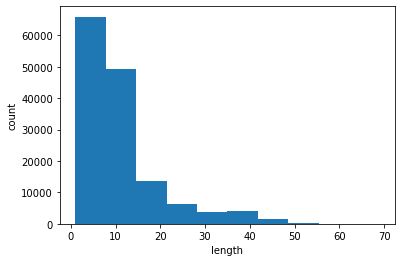

In [68]:
plt.hist([len(review) for review in X_train])
plt.xlabel('length')
plt.ylabel('count')
plt.show()
#max_length = ??

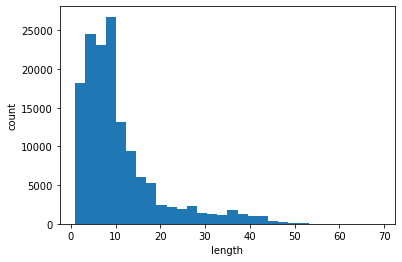

In [70]:
plt.hist([len(review) for review in X_train], bins = 30) # 좀 더 촘촘히
plt.xlabel('length')
plt.ylabel('count')
plt.show()

In [71]:
# Padding
max_length = 40
X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

### Generate a model

In [75]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100 # 임베딩할 수 있는 차원
# 1.Sequences
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid'))

# gd(gradient descent - 시간이 오래 걸림), sgd(local minima), momentum(minima 이전에 종료), adagrad(gradient 제곱, 0이 될 수 있음)
# rmsprop, adam = (momentum + rmsprop)
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

In [76]:
# 2.Model
i = Input(shape = (40, )) # max_length
x = Embedding(vocab_size, embedding_dim)(i)
x = LSTM(128)(x)
x = Dense(1, activation = 'sigmoid')(x)

model2 = Model(i, x)
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
model2.summary()

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4) # 4번 초과 반복되면 정지.
mc = ModelCheckpoint('review_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
r = model.fit(X_train, Y_train, epochs = 20, validation_split = 0.2, callback = [es, mc])